<a href="https://colab.research.google.com/github/Swetha-dev23/climate-change-pattern-recognition/blob/main/climate_change_pattern_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install earthengine-api geemap folium rasterio geopandas statsmodels scikit-learn tensorflow pymannkendall


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.9 MB/s eta 0:00:00


In [7]:
import ee, geemap

# Authenticate (only once)
ee.Authenticate()

# Initialize with your active project ID
ee.Initialize(project='lexical-period-414916')



In [8]:
# Example region: India bounding box
aoi = ee.Geometry.Polygon(
  [[[68, 6], [97, 6], [97, 36], [68, 36], [68, 6]]]
)

# Time period
start = '2000-02-18'
end   = '2025-10-31'


In [9]:
ndvi = (ee.ImageCollection('MODIS/061/MOD13Q1')  # 16-day composites
        .filterDate(start, end)
        .select('NDVI')
        .map(lambda img: img.clip(aoi)))


In [10]:
def yearly_median(year):
    y = ee.Number(year)
    return ndvi.filter(ee.Filter.calendarRange(y, y, 'year')).median().set('year', y)

years  = ee.List.sequence(2000, 2025)
annual = ee.ImageCollection(years.map(yearly_median))


In [12]:
def add_time(img):
    return img.addBands(ee.Image.constant(ee.Number(img.get('year'))).rename('t'))

trend = (annual.map(add_time)
         .select(['t','NDVI'])
         .reduce(ee.Reducer.linearFit()))


In [13]:
Map = geemap.Map(center=[20,78], zoom=4)
Map.addLayer(trend.select('scale'),
             {'min':-100, 'max':100, 'palette':['blue','white','red']},
             'NDVI Trend (2000–2025)')
Map


Map(center=[20, 78], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

In [14]:
task = ee.batch.Export.image.toDrive(
    image=trend.select('scale'),
    description='NDVI_trend_India',
    fileFormat='GeoTIFF',
    region=aoi,
    scale=1000,
    maxPixels=1e13
)
task.start()


In [16]:
# Define the function that adds a consistent time band
def add_time(img):
    year = ee.Number(img.get('year')).float()          # ensure float
    t_band = ee.Image.constant(year).rename('t')       # create constant image band
    img = img.addBands(t_band)
    return img.cast({'NDVI': 'float', 't': 'float'})   # enforce uniform type for all bands

# Map it across your annual composites
annual_with_time = annual.map(add_time)

# Linear regression to compute slope and intercept
trend = annual_with_time.select(['t', 'NDVI']).reduce(ee.Reducer.linearFit())


In [17]:
stats = trend.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=aoi,
    scale=1000,
    maxPixels=1e13
)
print('Mean NDVI trend:', stats.get('scale').getInfo())


Mean NDVI trend: 21.19266320680718


In [19]:
Map = geemap.Map(center=[20, 78], zoom=4)
Map.addLayer(trend.select('scale').divide(10000),
             {'min': -0.005, 'max': 0.005, 'palette': ['blue', 'white', 'green']},
             'NDVI Trend (ΔNDVI/year)')
Map


Map(center=[20, 78], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

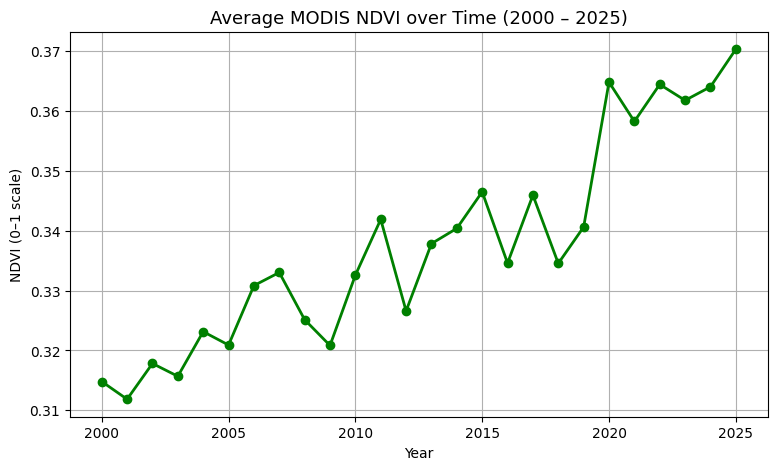

,Year,Mean_NDVI
0,2000,0.314800
1,2001,0.311843
2,2002,0.317814
3,2003,0.315677
4,2004,0.323133


In [20]:
# --- Step 8 : Plot the NDVI trend as a line graph ----------------------

# Compute the mean NDVI inside your AOI for each year
def mean_ndvi(img):
    mean_dict = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=1000,
        maxPixels=1e13
    )
    # store the year and mean NDVI value as a feature
    return ee.Feature(None, {
        'year': img.get('year'),
        'NDVI': mean_dict.get('NDVI')
    })

# Apply the function to every annual image
yearly_ndvi = ee.FeatureCollection(annual.map(mean_ndvi))

# Convert the Earth Engine FeatureCollection into Python lists
import pandas as pd
info = yearly_ndvi.getInfo()
years = [f['properties']['year'] for f in info['features']]
ndvi_vals = [f['properties']['NDVI'] for f in info['features']]

# Build a clean DataFrame
df = pd.DataFrame({'Year': years, 'Mean_NDVI': ndvi_vals})
df = df.sort_values('Year')
df['Mean_NDVI'] = df['Mean_NDVI'] / 10000.0   # MODIS scale correction

# Plot the line graph
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5))
plt.plot(df['Year'], df['Mean_NDVI'], marker='o', color='green', linewidth=2)
plt.title('Average MODIS NDVI over Time (2000 – 2025)', fontsize=13)
plt.xlabel('Year')
plt.ylabel('NDVI (0–1 scale)')
plt.grid(True)
plt.show()

# Optionally show the raw table
df.head()
